In [1]:
import os
import sys
sys.path.append('/shared/homes/sguan/Coding_Projects/PyNeuroSG')
import numpy as np
import scipy as sp
import pandas as pd         # pandas tabular DataFrame for task/behavioral data
import matplotlib as mpl    # plot
import matplotlib.pyplot as plt
import re                   # regular expression
import time                 # time code execution
# ----- modules used to read neuro data -----
import dg2df                # for DLSH dynamic group (behavioral data)
import neo                  # data structure for neural data
import quantities as pq
# ----- modules of the project PyNeuroSG -----
import PyNeuroData as pnd   # in this package: align neural data according to task
import PyNeuroAna as pna    # in this package: analysis
import PyNeuroPlot as pnp   # in this package: plot
import misc_tools           # in this package: misc
# ----- modules for the data location and organization in Sheinberg lab -----
import data_load_DLSH       # package specific for DLSH lab data
from GM32_layout import layout_GM32

%matplotlib inline

In [2]:

dir_tdt_tank = '/shared/lab/projects/encounter/data/TDT'
dir_dg='/shared/lab/projects/analysis/ruobing/data_dg'

f_lim = [30,55]
stimulate_type = 0
signal_type = ['spk','LFP', 'spcg']
keyword_tank = '.*Thor.*180715.*'
task_type = 'spot'
if task_type=='spot':
    keyword_block= 'h.*V4_spot.*'
    group_by = ['stim_pos_x', 'stim_pos_y']
    t_range = [-0.1, 0.4]
elif task_type=='colorxgrating':
    keyword_block = 'h.*texture.*'
    group_by = ['orient', 'hue']
    t_range = [-0.2, 0.5]
elif task_type=='fft':
    keyword_block = 'h.*imageopto.*'
    group_by = ['orient']
    t_range = [-0.2, 0.5]
elif task_type=='MTS':
    keyword_block = 'h.*detection.*'
    group_by = ['SampleOrientation']
    t_range = [-0.6, 1.5]

# if 'task_type2' not in locals() or task_type2 != task_type:
#     task_type2 = task_type
#     load_files = True
# elif task_type2 == task_type:
#     load_files = False
load_files = True

""" load data: (1) neural data: TDT blocks -> neo format; (2)behaverial data: stim dg -> pandas DataFrame """
if load_files:
    [blk, data_df, name_tdt_blocks] = data_load_DLSH.load_data(keyword_block, keyword_tank, tf_interactive=False,
                                                               dir_tdt_tank=dir_tdt_tank, dir_dg=dir_dg)
    if task_type=='colorxgrating':
        data_df['orient'] = np.array(data_df['stim_names'].str.extract('fftnoise_(\d\d\d)_.*'),
                                           dtype=float) / 180 * np.pi
    if task_type=='MTS':
        data_df['stimulate_type'] = data_df['StimulateType']

    filename_common = misc_tools.str_common(name_tdt_blocks)

    data_df = data_load_DLSH.standardize_data_df(data_df, filename_common)
    blk = data_load_DLSH.standardize_blk(blk)

    # Get StimOn time stamps in neo time frame
    ts_StimOn = data_load_DLSH.get_ts_align(blk, data_df, dg_tos_align='stimon')

    # some settings for saving figures
    filename_common = misc_tools.str_common(name_tdt_blocks)
    dir_temp_fig = './temp_figs'




""" data align """

data_neuro_spk = pnd.blk_align_to_evt(blk, ts_StimOn, t_range, type_filter='spiketrains.*',
                                           name_filter='.*Code[1-9]$', spike_bin_rate=1000)

data_neuro_LFP = pnd.blk_align_to_evt(blk, ts_StimOn, t_range, type_filter='ana.*', name_filter='LFPs.*')

# calculate power spectrum
if 'spcg' in signal_type:
    [spcg, spcg_t, spcg_f] = pna.ComputeSpectrogram(data_neuro_LFP['data'], fs=data_neuro_LFP['signal_info']['sampling_rate'][0],
                           t_ini=data_neuro_LFP['ts'][0], t_bin=0.100, t_step=0.1/2, t_axis=1, batchsize=100,
                           f_lim=[5,100])




the following tdt blockes are selected: ['h_V4_spot_071518020']
the following dg files are selected: ['h_V4_spot_071018002', 'h_V4_spot_071018003', 'h_V4_spot_071118011', 'h_V4_spot_071318019', 'h_V4_spot_071318020', 'h_V4_spot_071418019', 'h_V4_spot_071518020']
the their intersections are: ['h_V4_spot_071518020']

the data files to be loaded are: ['h_V4_spot_071518020']
loading TDT block: h_V4_spot_071518020
finish loading tdt blocks
loading dg: h_V4_spot_071518020.dg
finish loading and concatenating dgs


In [4]:
""" group by x,y cooridnate """

if 'stimulate_type' in data_df.keys():
    trial_filter = np.in1d(data_df['stimulate_type'],stimulate_type)
elif 'StimulateType' in data_df.keys():
    trial_filter = np.in1d(data_df['StimulateType'],stimulate_type)
else:
    trial_filter = []

data_neuro_spk = pnd.neuro_sort(data_df, group_by, trial_filter, data_neuro_spk)
data_neuro_LFP = pnd.neuro_sort(data_df, group_by, trial_filter, data_neuro_LFP)
if 'spcg' in signal_type:
    data_neuro_spcg = {}
    data_neuro_spcg['data'] = np.mean(spcg[:, np.logical_and(spcg_f >= f_lim[0], spcg_f < f_lim[1]), :, :],
                                      axis=1).transpose([0, 2, 1])
    data_neuro_spcg['ts'] = spcg_t
    data_neuro_spcg['signal_info'] = data_neuro_LFP['signal_info']
    data_neuro_spcg['fltr'] = data_neuro_LFP['fltr']
    data_neuro_spcg['grpby'] = data_neuro_LFP['grpby']
    data_neuro_spcg['cdtn'] = data_neuro_LFP['cdtn']
    data_neuro_spcg['cdtn_indx'] = data_neuro_LFP['cdtn_indx']


if signal_type == 'spk':
    data_neuro = data_neuro_spk
elif signal_type == 'LFP':
    data_neuro = data_neuro_LFP
elif  'spcg' in signal_type:
    data_neuro = data_neuro_spcg

def plot_RF(t_window_plot=t_range, signal_type=signal_type,data_neuro = data_neuro,label = data_df[group_by[0]]):
    h_fig, h_axes = pnp.create_array_layout_subplots(layout_GM32, tf_linear_indx=True)
    h_fig.set_size_inches([10, 9], forward=True)
    plt.tight_layout()

    for i in sorted(range(len(data_neuro['signal_info'])), reverse=True):
        ch = data_neuro['signal_info'][i]['channel_index']
        if ch <= 32:
            plt.axes(h_axes[ch - 1])
            if len(group_by) == 2:
                pnp.RfPlot(data_neuro, indx_sgnl=i, t_focus=t_window_plot,
                       psth_overlay=False, tf_scr_ctr=True)
            elif len(group_by)==1:
                tuning_x, tuning_y =pna.TuningCurve(data_neuro['data'][:, :, i], label,
                                ts=data_neuro['ts'], t_window=t_window_plot)
                plt.plot(tuning_x, tuning_y, 'o-')
    return h_fig, h_axes

Text(0.5,0.98,'h_V4_spot_071518020_spk')

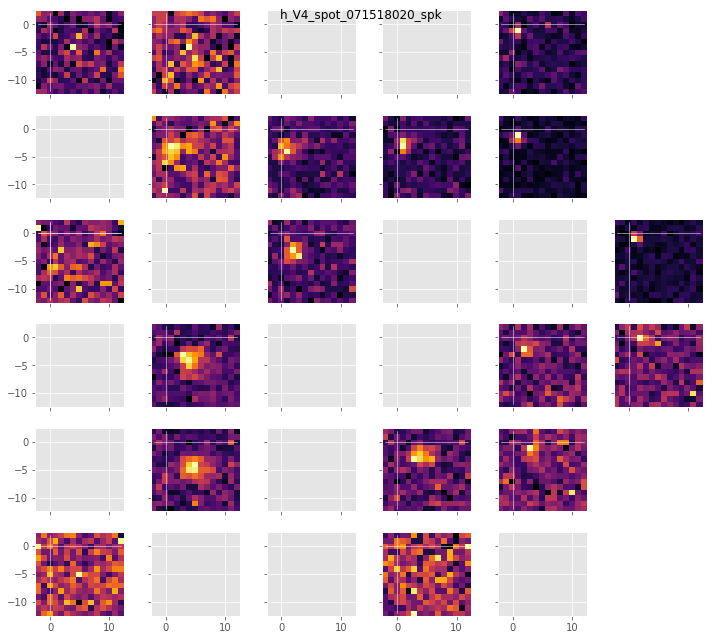

In [7]:
plot_RF(t_window_plot=[0.05,0.25], signal_type=signal_type,data_neuro = data_neuro_spk)
plt.suptitle('{}_{}'.format(filename_common, 'spk'))

Text(0.5,0.98,'h_V4_spot_071518020_LFP')

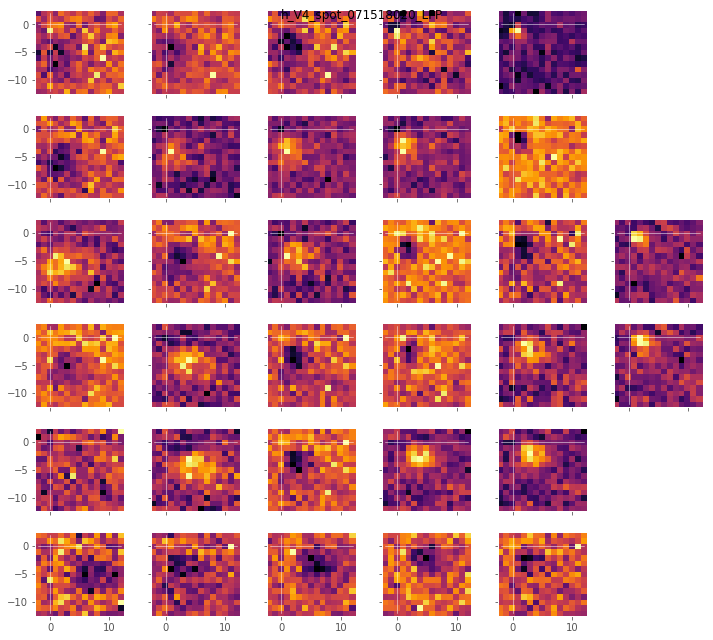

In [5]:
plot_RF(t_window_plot=[0.05,0.25], signal_type=signal_type,data_neuro = data_neuro_LFP)
plt.suptitle('{}_{}'.format(filename_common, 'LFP'))

Text(0.5,0.98,'h_V4_spot_071518020_spcg')

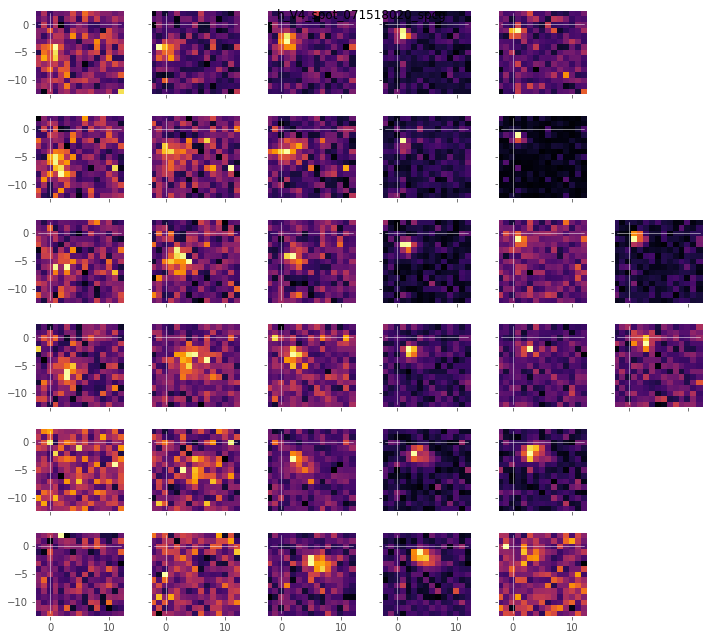

In [6]:
plot_RF(t_window_plot=[0.05,0.25], signal_type=signal_type,data_neuro = data_neuro_spcg)
plt.suptitle('{}_{}'.format(filename_common, 'spcg'))

/shared/homes/rxia/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


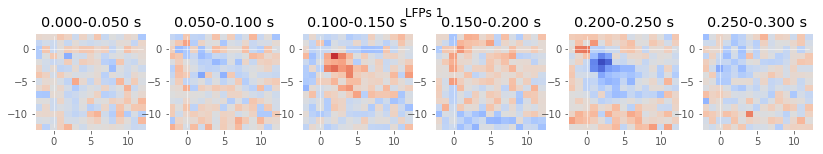

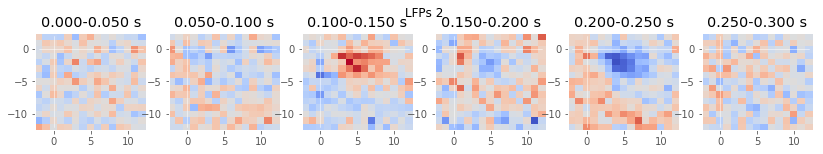

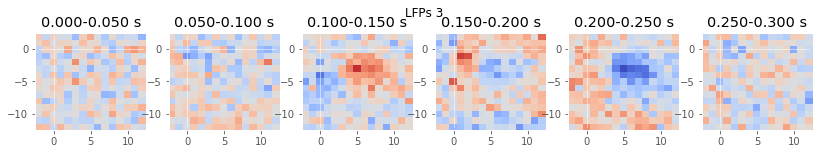

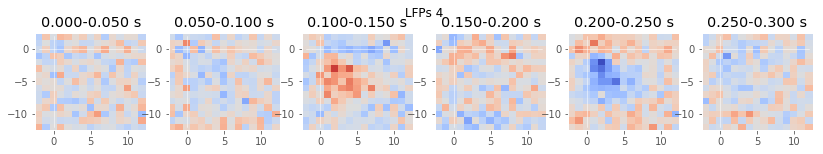

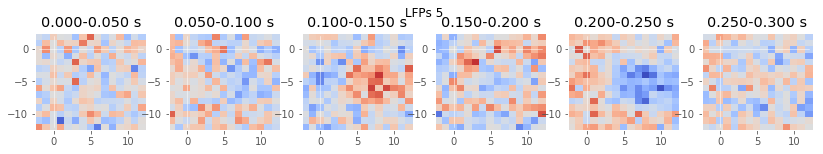

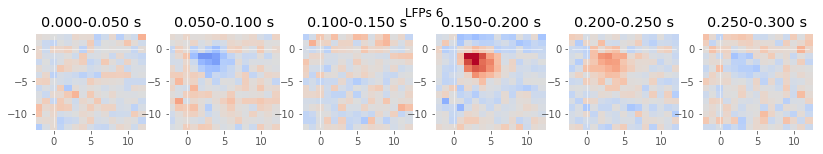

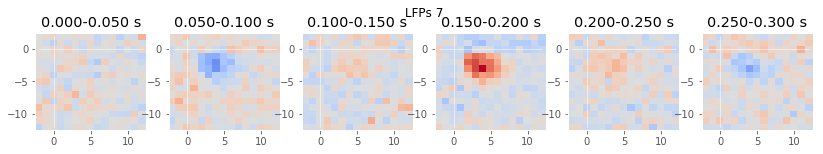

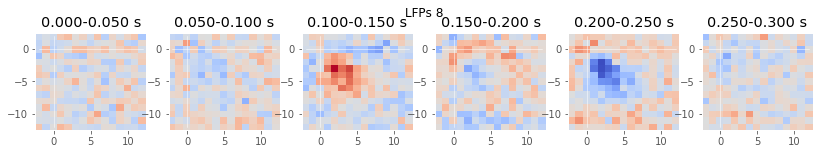

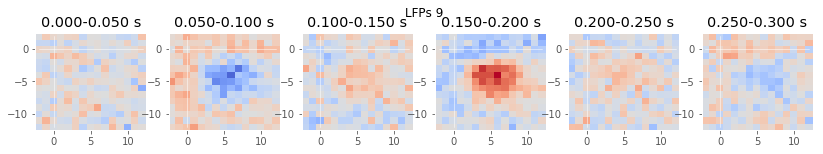

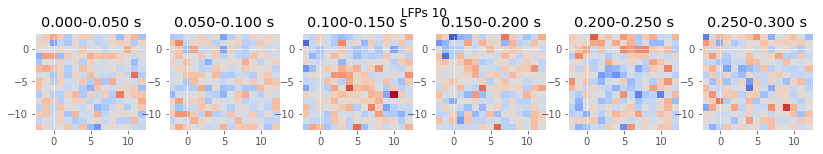

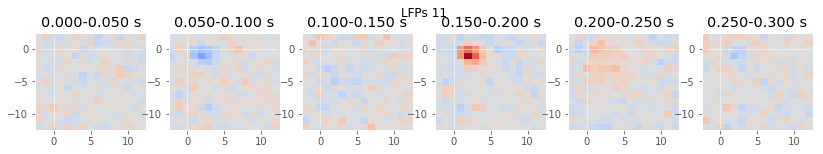

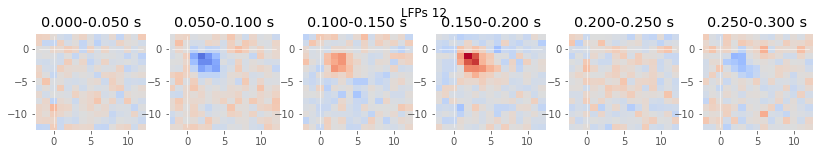

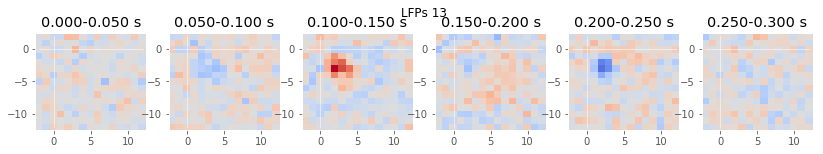

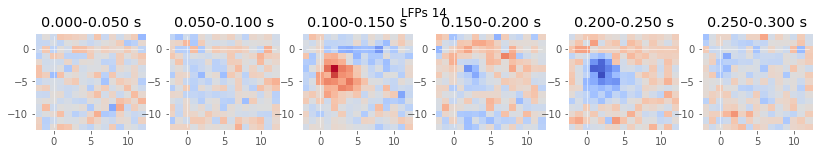

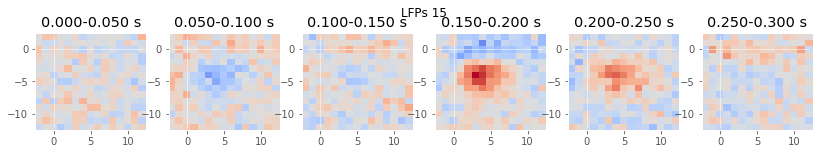

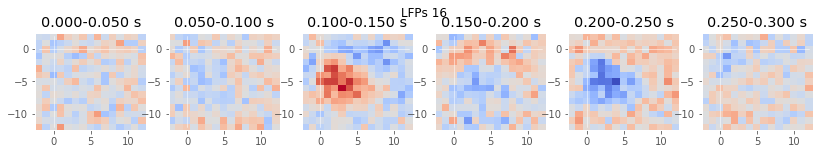

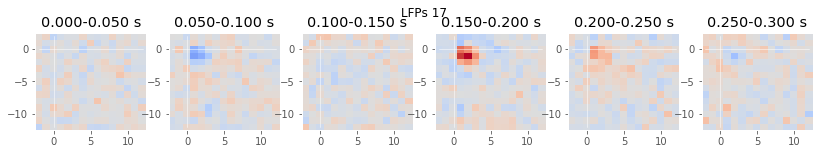

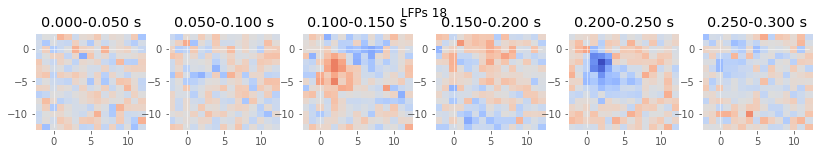

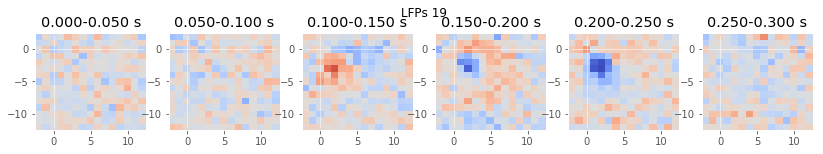

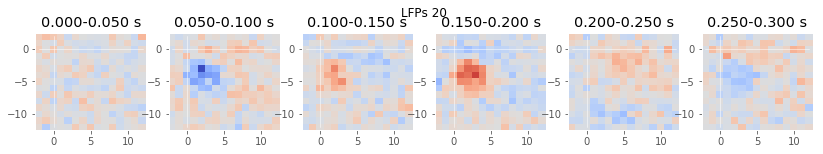

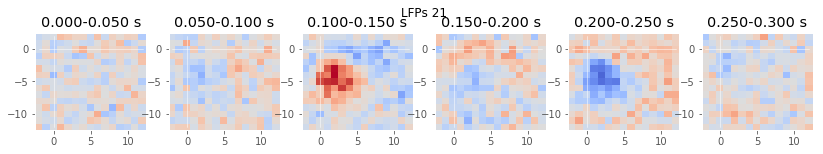

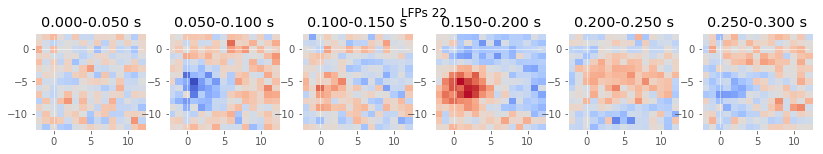

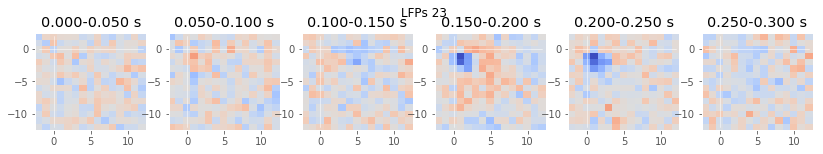

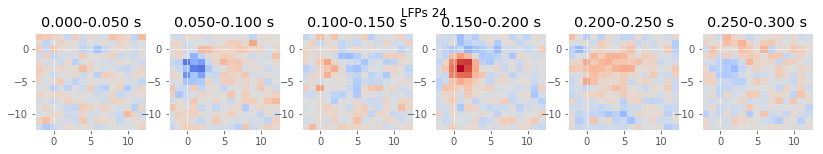

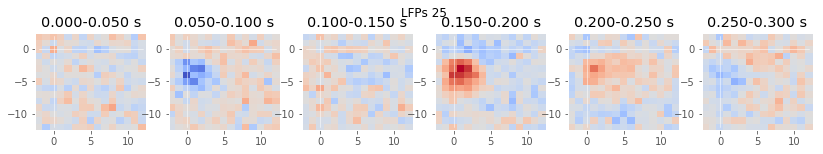

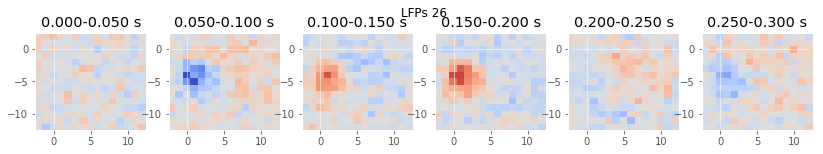

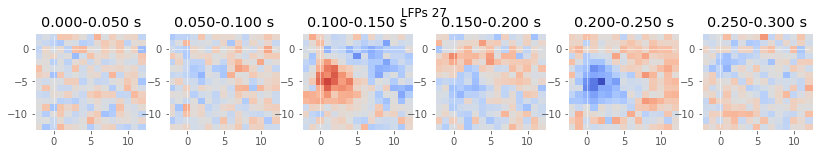

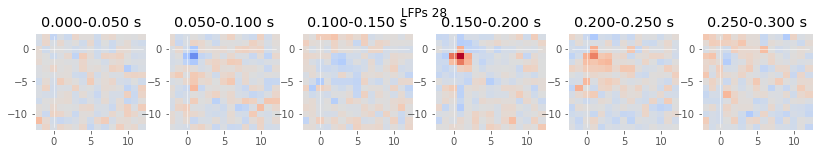

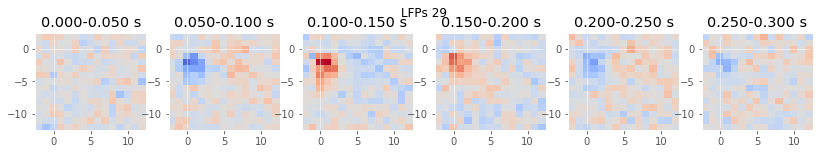

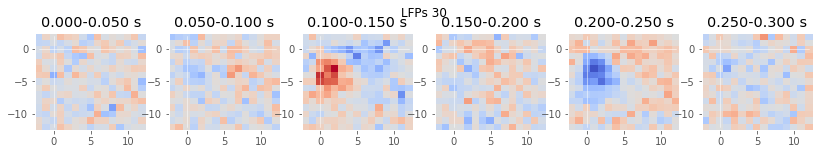

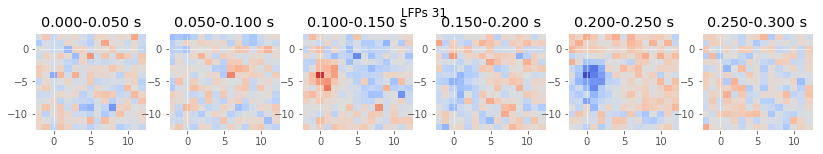

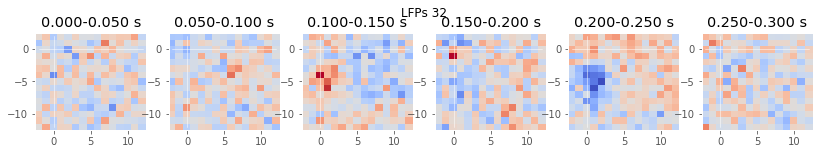

In [8]:
t_window_dur = 0.05
t_window_starts = np.arange(0, 0.3, 0.05)
data_neuro = data_neuro_LFP
for i_signal in range(len(data_neuro['signal_info'])):
    h_fig, h_axes = plt.subplots(1, len(t_window_starts), figsize=(12, 2))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.8)
    for i, t_window_start in enumerate(t_window_starts):
        t_window_plot = [t_window_start, t_window_start+t_window_dur]
        plt.axes(h_axes[i])
        pnp.RfPlot(data_neuro, indx_sgnl=i_signal, t_focus=t_window_plot, psth_overlay=False, tf_scr_ctr=True)
        plt.title('{:.3f}-{:.3f} s'.format(t_window_start, t_window_start+t_window_dur))
    clim = pnp.share_clim(h_axes)
    clim = [-np.max(np.abs(clim)), np.max(np.abs(clim))]
    clim = pnp.share_clim(h_axes, c_lim=clim, cmap='coolwarm')
    plt.suptitle(data_neuro['signal_info']['name'][i_signal])

/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


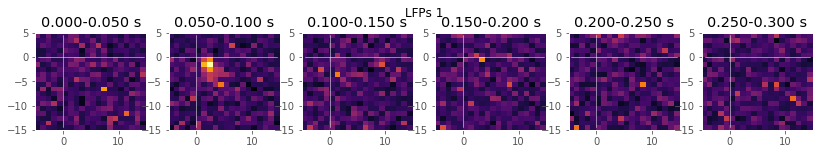

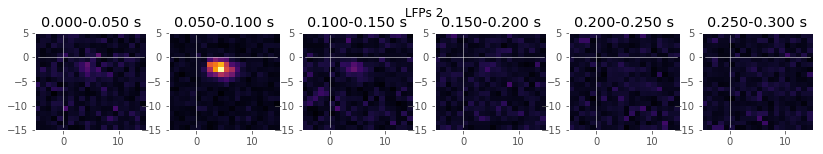

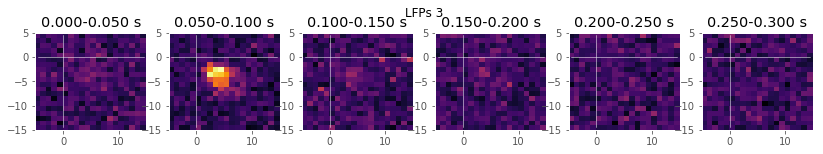

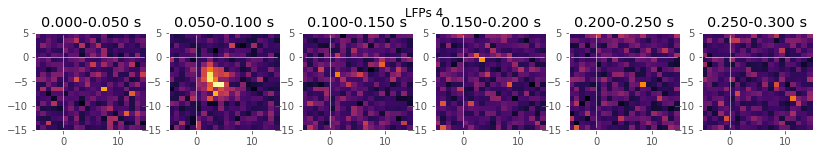

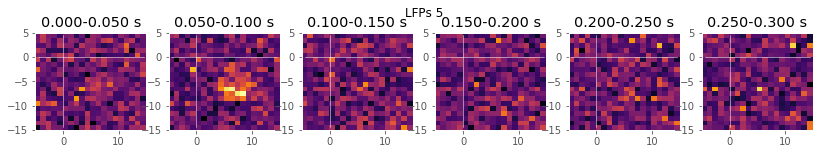

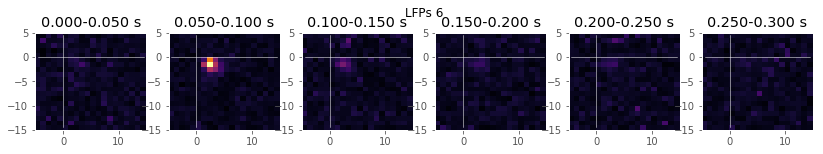

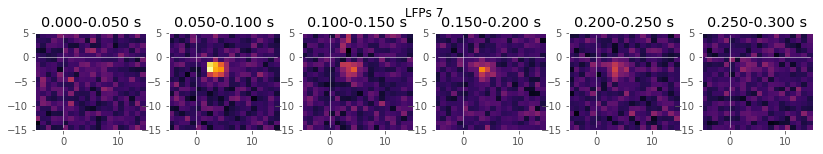

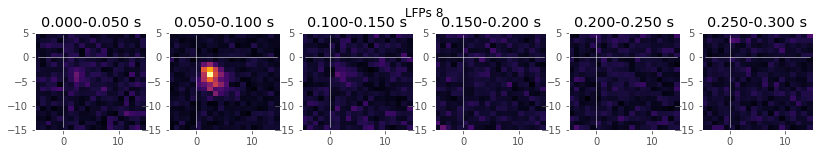

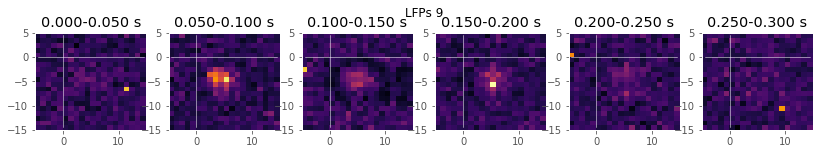

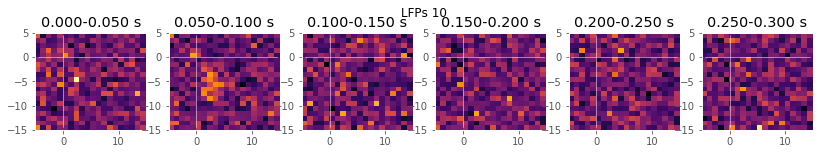

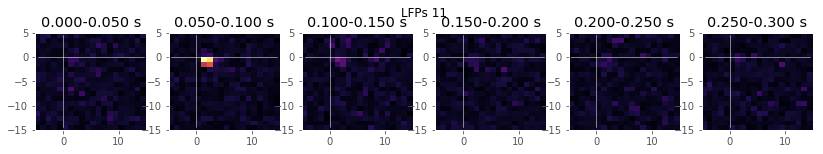

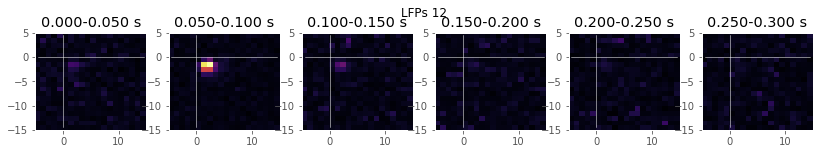

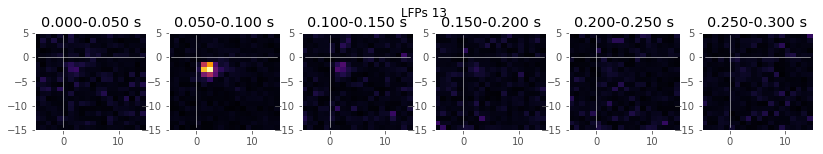

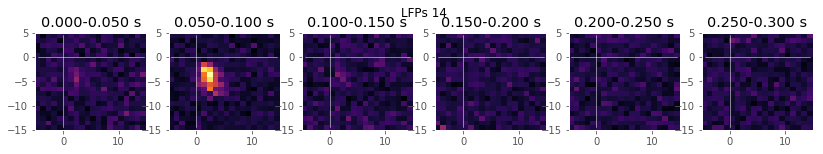

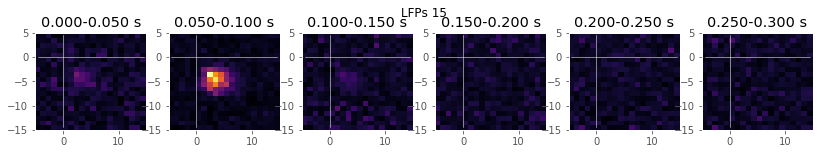

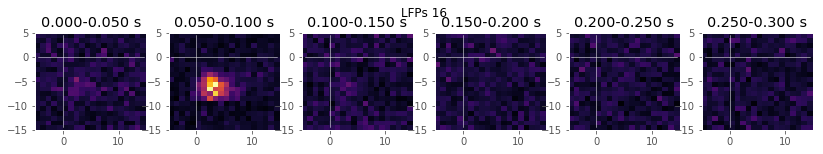

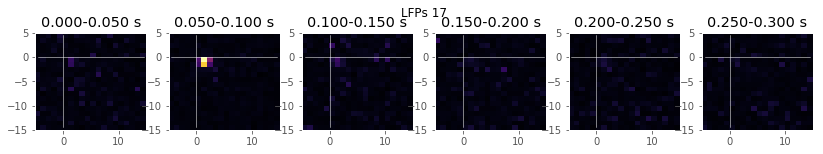

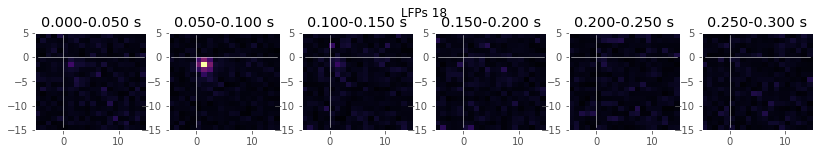

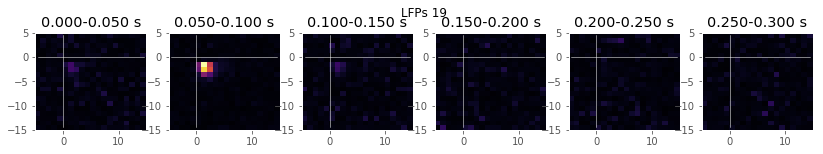

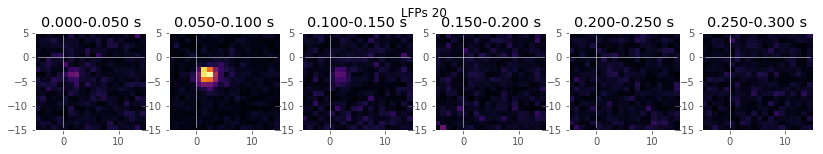

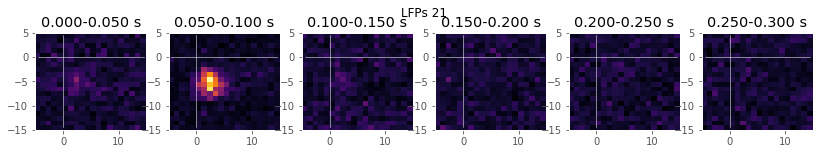

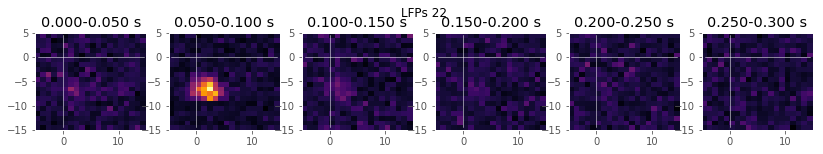

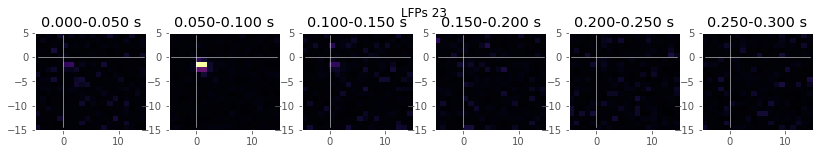

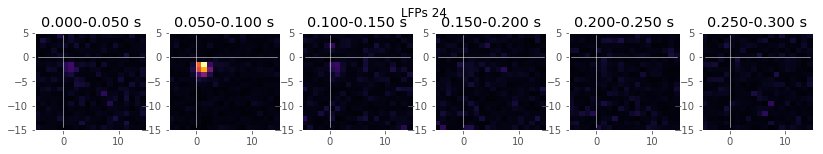

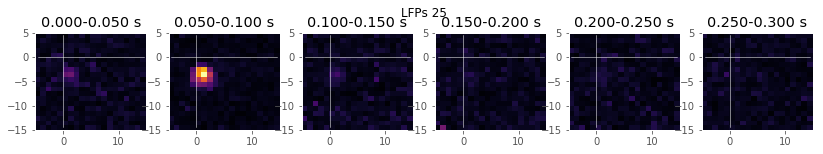

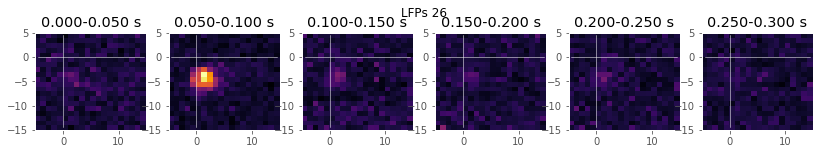

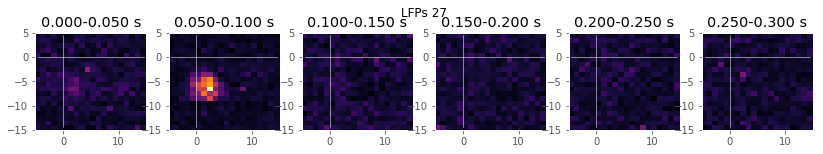

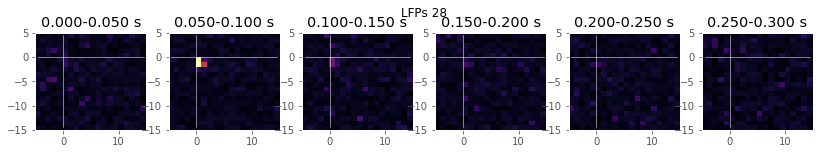

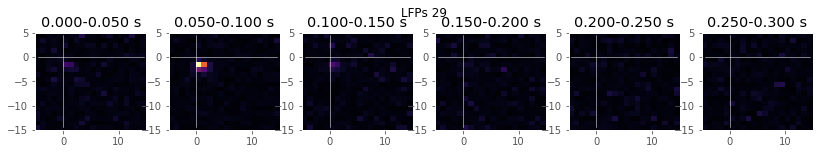

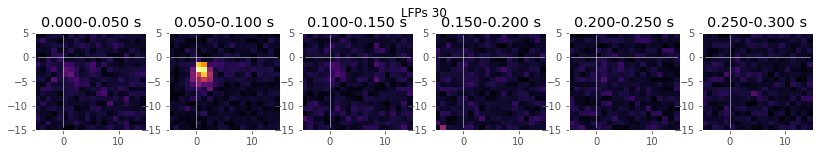

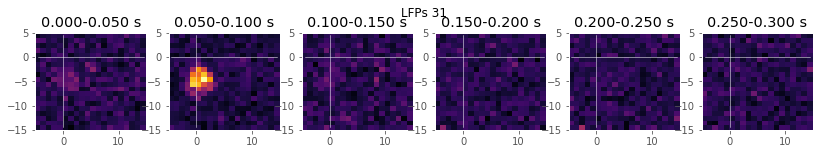

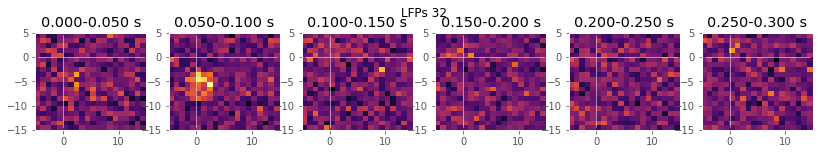

In [17]:
t_window_dur = 0.05
t_window_starts = np.arange(0, 0.3, 0.05)
data_neuro = data_neuro_spcg
for i_signal in range(len(data_neuro['signal_info'])):
    h_fig, h_axes = plt.subplots(1, len(t_window_starts), figsize=(12, 2))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.8)
    for i, t_window_start in enumerate(t_window_starts):
        t_window_plot = [t_window_start, t_window_start+t_window_dur]
        plt.axes(h_axes[i])
        pnp.RfPlot(data_neuro, indx_sgnl=i_signal, t_focus=t_window_plot, psth_overlay=False, tf_scr_ctr=True)
        plt.title('{:.3f}-{:.3f} s'.format(t_window_start, t_window_start+t_window_dur))
    clim = pnp.share_clim(h_axes)
    plt.suptitle(data_neuro['signal_info']['name'][i_signal])